In [2]:
#EXERCISE 3

In [50]:
from datetime import datetime
import numpy as np
import datetime
import pandas as pd

In [2]:
import wrds
db=wrds.Connection(wrds_username='perusset')

Loading library list...
Done


In [3]:
# Risk-Free Rate:
Rf=db.raw_sql("select  mcaldt,tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1960-01-01'and mcaldt<='2023-12-31'", 
              date_cols=['mcaldt'])

Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


# Stock Index (MSCI)
Stocks=db.raw_sql("select  date,vwretd from crsp.msi where date>='1960-01-01'and date<='2023-12-31'", 
                date_cols=['date'])

# Bonds
Bonds=db.raw_sql("select  caldt, b2ret from crsp.mcti where caldt>='1960-01-01'and caldt<='2023-12-31'",
                 date_cols=['caldt'])
Bonds=Bonds.rename(columns={ "caldt": "date"})

# Merge and export
data = pd.merge(Stocks,Bonds,how='left')
data = pd.merge(data,Rf,how='left')
data = data.rename(columns={ "caldt": "date",'b2ret':'Bonds','vwretd':'Stocks'})
data = data.dropna()
data.to_csv('data.csv', sep=';',index=False)


In [51]:
# Import the data
data = pd.read_csv("data.csv",sep=";")
data

,date,Stocks,Bonds,rf
0,1960-01-29,-0.066244,0.009443,0.002860
1,1960-02-29,0.014419,0.008344,0.003179
2,1960-03-31,-0.012822,0.014125,0.002117
3,1960-04-29,-0.015271,-0.003661,0.002414
4,1960-05-31,0.034098,0.006015,0.001947
...,...,...,...,...
762,2023-08-31,-0.020605,0.003920,0.004473
763,2023-09-29,-0.047390,-0.000046,0.004482
764,2023-10-31,-0.028867,0.002601,0.004485
765,2023-11-30,0.092057,0.011704,0.004465


## Return Statistics
Unconditional Means, Variances, Sharpe Ratio of raw returns and portfolios

In [52]:
data["rf"].mean()*12

0.041891912700374054

In [53]:
def compute_statistics(data, Time_frame):
    
    #-----------------------------
    # Time Frame
    #-----------------------------  
    data_t = data[(data.date>Time_frame[0]) & 
                  (data.date<Time_frame[1])].copy()
    
    
    #-----------------------------
    # Raw Returns
    #-----------------------------
    riskfree=data_t["rf"].mean()

    data_t["Mix60_40"]=0.4*data_t["Bonds"]+0.6*data_t["Stocks"]
    bonds_mean=data_t["Bonds"].mean()*12
    bonds_vol=data_t["Bonds"].std()*np.sqrt(12)

    stocks_mean=data_t["Stocks"].mean()*12
    stocks_vol=data_t["Stocks"].std()*np.sqrt(12)

    mix_mean=data_t["Mix60_40"].mean()*12
    mix_vol=data_t["Mix60_40"].std()*np.sqrt(12)

    bonds_sr=(bonds_mean-riskfree*12)/bonds_vol
    stocks_sr=(stocks_mean-riskfree*12)/stocks_vol
    mix_sr=(mix_mean-riskfree*12)/mix_vol
    
    
    #-----------------------------
    # Risk Parity PORTFOLIO
    #-----------------------------
    print('RP Weight Stocks:', 1/stocks_vol/(1/bonds_vol+1/stocks_vol))
    data_t["Risk_Parity"]=(1/bonds_vol*data_t["Bonds"]+1/stocks_vol*data_t["Stocks"])/(1/bonds_vol+1/stocks_vol)
    RP_mean=data_t["Risk_Parity"].mean()*12
    RP_vol=data_t["Risk_Parity"].std()*np.sqrt(12)
    k=mix_vol/RP_vol
    data_t["Risk_Parity_levered"]=k*data_t["Risk_Parity"]+(1-k)*data_t["rf"]

    rp_mean=data_t["Risk_Parity"].mean()*12
    rp_vol=data_t["Risk_Parity"].std()*np.sqrt(12)

    rp_levered_mean=data_t["Risk_Parity_levered"].mean()*12
    rp_levered_vol=data_t["Risk_Parity_levered"].std()*np.sqrt(12)

    rp_sr=(rp_mean-riskfree*12)/rp_vol
    rp_levered_sr=(rp_levered_mean-riskfree*12)/rp_levered_vol
    
    
    #-----------------------------
    # Tangency PORTFOLIO
    #-----------------------------
    # cov matrix and expected returns
    cov_matrix = data_t[["Stocks","Bonds"]].cov().values*12
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    rho = data_t[["Stocks","Bonds"]].corr().iloc[0,1]
    mu = np.array([stocks_mean-riskfree*12,bonds_mean-riskfree*12])

    # Weights in tangency portfolio 
    w_stocks= (inv_cov_matrix @ mu)/(np.ones(2)@inv_cov_matrix@mu)
    print('Tangency Weight Stocks:', w_stocks[0])

    # Summary stats of tangency portfolio
    data_t["tan"]=(w_stocks[1]*data_t["Bonds"]+w_stocks[0]*data_t["Stocks"])
    tan_mean=data_t["tan"].mean()*12
    tan_vol=data_t["tan"].std()*np.sqrt(12)
    tan_sr=(tan_mean-riskfree*12)/tan_vol
    
    #-----------------------------
    # Store Results
    #-----------------------------
    labels = ['Stocks','Bonds','Mix','RP','RP levered','Tan']
    MU = pd.Series([stocks_mean,bonds_mean,mix_mean,rp_mean,rp_levered_mean,tan_mean], index=labels)
    STD = pd.Series([stocks_vol,bonds_vol,mix_vol,rp_vol,rp_levered_vol,tan_vol], index=labels)
    SR =pd.Series([stocks_sr,bonds_sr,mix_sr,rp_sr,rp_levered_sr,tan_sr], index=labels)
    
    return data_t.set_index('date'), MU, STD, SR, cov_matrix, rho, riskfree

Time_frame = ['1960-01-01','2023-01-01']
data_t, MU, STD, SR, cov_matrix, rho, riskfree = compute_statistics(data,Time_frame)

RP Weight Stocks: 0.15424795600164107
Tangency Weight Stocks: 0.15226539671762515


In [45]:
# Print Results
def construct_stats_table(MU, STD, SR, cov_matrix,title):
    index = ['Stocks', 'Bonds', '60/40','Risk Parity','Risk Parity levered','Tangency Portfolio']
    pStats = pd.DataFrame({'Mean' : MU.round(3), 
                        'Volatility' : STD.round(3),
                        'Sharpe Ratio' : SR.round(3)
                          })
    pStats.index  = index

    print(title)
    display(np.around(pStats,6))
    return
construct_stats_table(MU, STD, SR, cov_matrix,'Summary Statistics Full Sample')

Summary Statistics Full Sample


,Mean,Volatility,Sharpe Ratio
Stocks,0.106,0.154,0.416
Bonds,0.054,0.028,0.421
60/40,0.085,0.094,0.458
Risk Parity,0.062,0.035,0.566
Risk Parity levered,0.095,0.093,0.574
Tangency Portfolio,0.062,0.035,0.566


## Plot efficient Frontier

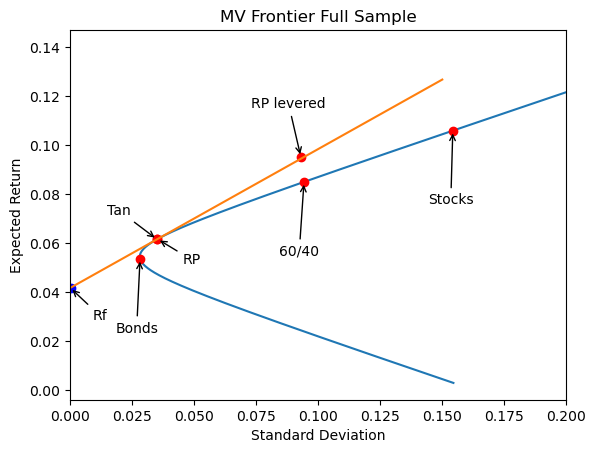

In [54]:
import matplotlib.pyplot as plt

def efficient_frontier_plot(MU,STD,cov_matrix, riskfree,title):

    #MV frontiers
    mu_p = np.linspace(0.003,0.14,1000)
    mu = MU[:2]
    ONES=np.ones(2)
    sigma_inv = np.linalg.inv(cov_matrix)

    A = (ONES@sigma_inv)@ONES
    B = (ONES@sigma_inv)@mu
    C = (mu@sigma_inv)@mu
    DELTA = A*C-B**2

    sigma_p = np.sqrt((A*np.multiply(mu_p,mu_p)-2*B*mu_p+C)/DELTA)

    plt.plot(sigma_p, mu_p)
    plt.xlabel('Standard Deviation')
    plt.ylabel('Expected Return')
    plt.plot(STD,MU,'ro')
    plt.plot(0.0001,riskfree*12,'bo')
    plt.xlim(0, 0.20)

    plt.annotate('Stocks', xy=(STD['Stocks'],MU['Stocks']), xytext=(STD['Stocks']-.01,MU['Stocks']-.03),
                arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('Bonds', xy=(STD['Bonds'],MU['Bonds']), xytext=(STD['Bonds']-.01,MU['Bonds']-.03),
                arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('RP', xy=(STD['RP'],MU['RP']), xytext=(STD['RP']+.01, MU['RP']-.01),
                arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('RP levered', xy=(STD['RP levered'],MU['RP levered']), xytext=(STD['RP levered']-.02, MU['RP levered']+.02),
                arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('60/40', xy=(STD['Mix'],MU['Mix']), xytext=(STD['Mix']-.01,MU['Mix']-.03),
                arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('Tan', xy=(STD['Tan'],MU['Tan']), xytext=(STD['Tan']-.02,MU['Tan']+.01),
                arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('Rf', xy=(0, riskfree*12), xytext=(.001+.008, riskfree*12-.013),
                arrowprops=dict(arrowstyle="->")          
                )
    sigma_values = np.linspace(0,0.15,100)

    # first plot
    efficient_line =riskfree*12+(MU['Tan']-riskfree*12)/STD['Tan']*sigma_values


    plt.plot(sigma_values,efficient_line)
    plt.title(title)
    plt.savefig(title + '.pdf')
    plt.show()

    return

efficient_frontier_plot(MU,STD,cov_matrix, riskfree,'MV Frontier Full Sample')


## Risk Parity Under different Correlation Regimes

In [55]:
# Recompute everything under different time frames
date_start = '1960-01-01'
split = '1990-01-01'
date_end = '2024-01-01'
data0, MU0, STD0, SR0, cov_matrix0, rho0, riskfree0 = compute_statistics(data,[date_start,date_end])
data1, MU1, STD1, SR1, cov_matrix1, rho1, riskfree1 = compute_statistics(data,[date_start,split])
data2, MU2, STD2, SR2, cov_matrix2, rho2, riskfree2 = compute_statistics(data,[split,date_end])
print(rho0, rho1, rho2)

# Output
construct_stats_table(MU0, STD0, SR0, cov_matrix0,'Full Sample')
construct_stats_table(MU1, STD1, SR1, cov_matrix1,'1960-1990')
construct_stats_table(MU2, STD2, SR2, cov_matrix2,'1990-2024')

RP Weight Stocks: 0.15416617196993562
Tangency Weight Stocks: 0.16121154713605618
RP Weight Stocks: 0.1850908531108672
Tangency Weight Stocks: 0.1917983380292547
RP Weight Stocks: 0.1080976705952774
Tangency Weight Stocks: 0.09280052285315826
0.09520324922816957 0.21940979114318368 -0.10050105082554797
Full Sample


,Mean,Volatility,Sharpe Ratio
Stocks,0.108,0.154,0.427
Bonds,0.053,0.028,0.409
60/40,0.086,0.094,0.468
Risk Parity,0.062,0.035,0.565
Risk Parity levered,0.095,0.093,0.573
Tangency Portfolio,0.062,0.036,0.565


1960-1990


,Mean,Volatility,Sharpe Ratio
Stocks,0.111,0.155,0.320
Bonds,0.072,0.035,0.311
60/40,0.095,0.097,0.352
Risk Parity,0.079,0.045,0.404
Risk Parity levered,0.100,0.097,0.403
Tangency Portfolio,0.079,0.046,0.404


1990-2024


,Mean,Volatility,Sharpe Ratio
Stocks,0.105,0.154,0.523
Bonds,0.037,0.019,0.643
60/40,0.078,0.092,0.577
Risk Parity,0.045,0.022,0.869
Risk Parity levered,0.105,0.088,0.907
Tangency Portfolio,0.043,0.021,0.873


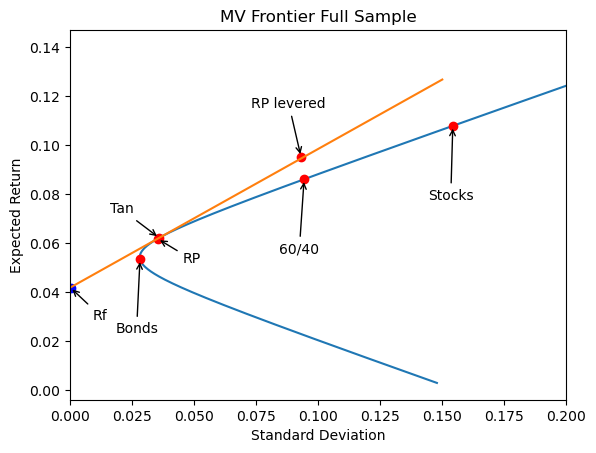

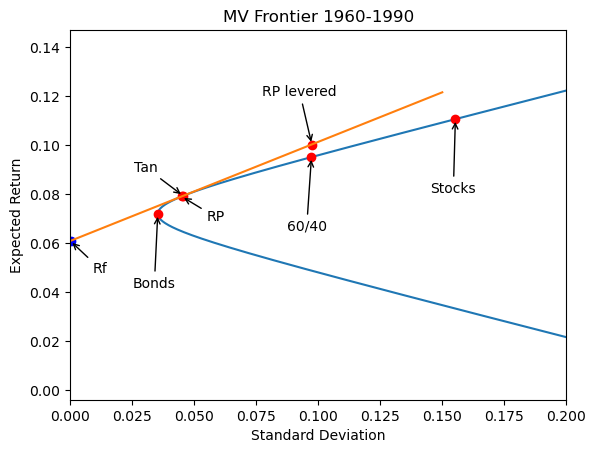

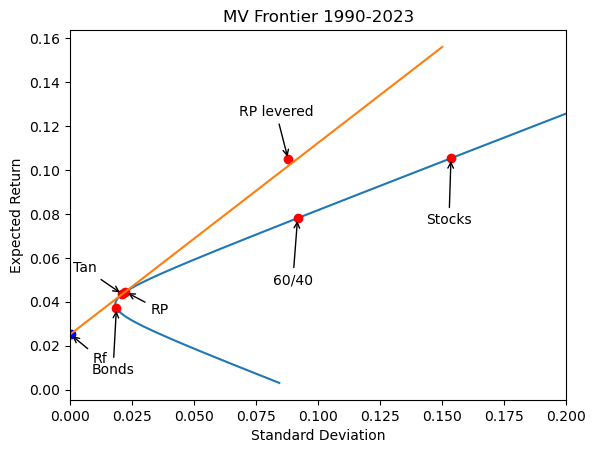

In [56]:
efficient_frontier_plot(MU0,STD0,cov_matrix0, riskfree0,'MV Frontier Full Sample')
efficient_frontier_plot(MU1,STD1,cov_matrix1, riskfree1,'MV Frontier 1960-1990')
efficient_frontier_plot(MU2,STD2,cov_matrix2, riskfree2,'MV Frontier 1990-2023')

Why does the RP portfolio not lie on the mean-variance efficient frontier?

It ignores both the expected return and the correlation of stocks and bonds.However, over the sample period, the tangency portfolio primarily invests in bonds. The RP portfolio also heavily overweights bonds because of their lower volatility. Hence the two portfolios lie very close to eachother and have almost the same sharpe ratio.

Text(0.5, 1.0, 'Sharpe Ratio')

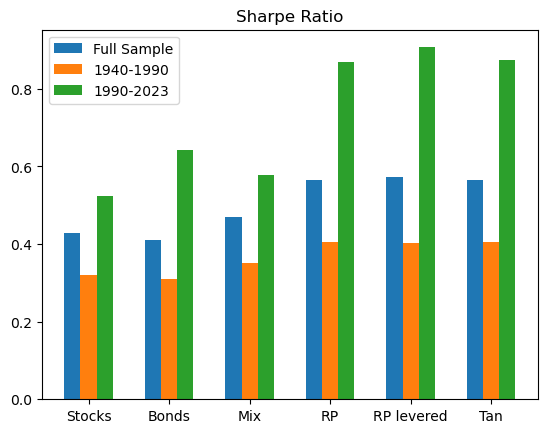

In [49]:
# Barplot
plt.bar(np.arange(len(SR0)) -0.2,SR0, 0.2)
plt.bar(np.arange(len(SR1)) ,SR1, 0.2)
plt.bar(np.arange(len(SR2)) + 0.2,SR2, 0.2)
plt.xticks(np.arange(len(SR0)), SR0.index)
plt.legend(['Full Sample','1940-1990','1990-2023'])
plt.title('Sharpe Ratio')